#**Aprendizaje Automático** - 2023
# Clase 7: Ensambles de modelos

*Trabajaron en esta notebook: Sofia Del Pozo, Diego Onna, Gaston Bujia*



## Contenidos

* Voting y Stacking
* Bagging
    * Random Forest
    * ERM: Extremely Randomized Trees
* Boosting
    * AdaBoost y Gradient Boosting
    * XGBoost: Extreme Gradient Boosting

In [157]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Función auxiliar para graficar frontera de decisión
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 500),
                         np.linspace(axes[2], axes[3], 500))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], alpha=0.65, linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

***
# Ensambles


Un modelo de ensamble (también conocido como "ensemble model" en inglés) es una técnica de aprendizaje automático que combina múltiples modelos de predicción individuales para mejorar la precisión y la generalización del modelo final. En un modelo de ensamble, se combinan de alguna manera los resultados de varios modelos de aprendizaje automático para obtener una predicción más precisa y confiable.

Scikit Learn cuenta un tipo de objetos llamados **meta-estimadores** para representar a los ensambles. Este nombre se debe a que estos meta-estimadores necesitan definir estimadores **base** que van a ser justamente los modelos que se ajusten en cada uno de los pasos de bootstrapping. Como modelos/estimadores base podemos instanciar cualquier estimador de sklearn pero no necesariamente todos tendrán sentido.

Generamos a continuación datos de semicirculos intercalados con [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) :

In [4]:
X, y = make_moons(n_samples=1000, noise=0.38, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Voting

[VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) es un método de ensamblado de modelos que combina múltiples modelos de clasificación para mejorar la precisión de las predicciones. Básicamente, se trata de un clasificador que utiliza una estrategia de votación para combinar las predicciones de varios clasificadores individuales y producir una única predicción final. Esto significa que cada clasificador vota por una etiqueta de clase, y la etiqueta más votada se elige como la predicción final del VotingClassifier. Puede ser utilizado con diferentes tipos de modelos de clasificación, como árboles de decisión, regresión logística, SVM, entre otros. El objetivo de utilizar VotingClassifier es aprovechar las fortalezas y limitaciones de cada modelo individual para mejorar el rendimiento general del modelo de clasificación.


El parámetro que siempre hay que definir en VotingClassifier es **estimators**, será una lista de los modelos de clasificación a utilizar.

In [10]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors = 3)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('svc', SVC(random_state=42))])

In [7]:
print(f"Accuracy training : {voting_clf.score(X_train, y_train):.3f}")
print(f"Accuracy test: {voting_clf.score(X_test, y_test):.3f}")

Accuracy training : 0.885
Accuracy test: 0.872


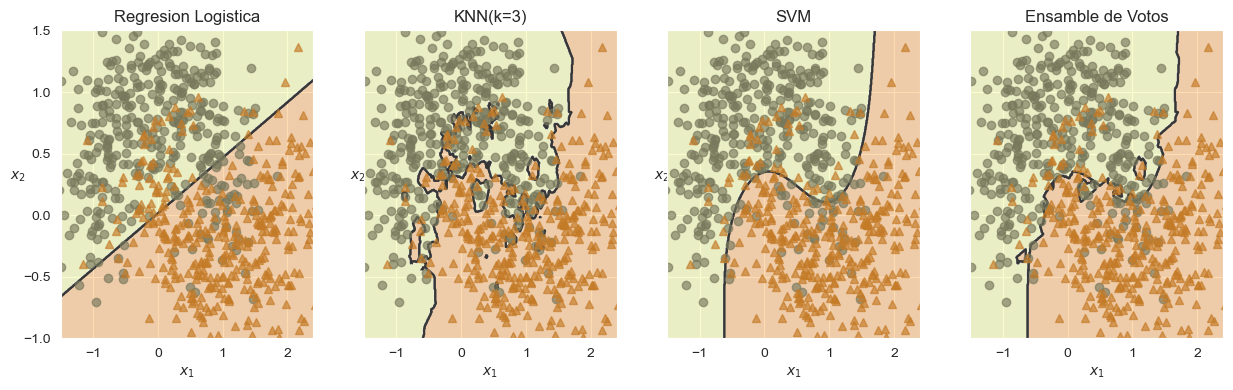

In [8]:
# Este codigo puede tardar un poco
fig, axes = plt.subplots(ncols=4, figsize=(15, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(voting_clf.named_estimators_['lr'], X_train, y_train)
plt.title("Regresion Logistica")
plt.sca(axes[1])
plot_decision_boundary(voting_clf.named_estimators_['knn'], X_train, y_train)
plt.title("KNN(k=3)")
plt.sca(axes[2])
plot_decision_boundary(voting_clf.named_estimators_['svc'], X_train, y_train)
plt.title("SVM")
plt.sca(axes[3])
plot_decision_boundary(voting_clf, X_train, y_train)
plt.title("Ensamble de Votos")
plt.ylabel("")
plt.show()

### Ejercicio 1

Comparar los cuatro modelos en `test`.

In [15]:
from sklearn.metrics import accuracy_score
LR = LogisticRegression(random_state=42)
LR.fit(X_train, y_train)
print(f"LR accuracy: {accuracy_score(y_test, LR.predict(X_test))}")

LR = KNeighborsClassifier(n_neighbors = 3)
LR.fit(X_train, y_train)
print(f"KNN accuracy: {accuracy_score(y_test, LR.predict(X_test))}")

LR = SVC(random_state=42)
LR.fit(X_train, y_train)
print(f"SVC accuracy: {accuracy_score(y_test, LR.predict(X_test))}")



LR accuracy: 0.844
KNN accuracy: 0.856
SVC accuracy: 0.868


## Stacking

[StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) es una técnica de aprendizaje supervisado que combina varios modelos de clasificación para formar un "supermodelo" que puede realizar predicciones más precisas.

En lugar de elegir un solo modelo de clasificación para hacer predicciones, StackingClassifier utiliza múltiples modelos de clasificación como "modelos de nivel inferior" para hacer predicciones en los datos de entrenamiento. Luego, las predicciones resultantes se utilizan como características de entrada para un "modelo de nivel superior", que aprende a combinar las predicciones de los modelos de nivel inferior para producir una predicción final más precisa. El modelo de nivel superior se entrena utilizando las características de entrada (predicciones) y las etiquetas de clase correspondientes de los datos de entrenamiento, y se ajusta para minimizar el error de predicción. En resumen, StackingClassifier utiliza múltiples modelos de clasificación para formar un "supermodelo" que combina las fortalezas y limitaciones de cada modelo individual para mejorar la precisión general del modelo de clasificación.

En el caso de Stacking, además de **estimators**, se tiene que definir **final_estimator** que será el modelo utilizado para la desición final.

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors = 3)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=DecisionTreeClassifier(random_state=42),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=DecisionTreeClassifier(random_state=42))

In [ ]:
print(f"Accuracy training : {stacking_clf.score(X_train, y_train):.3f}")
print(f"Accuracy test: {stacking_clf.score(X_test, y_test):.3f}")

Accuracy training : 0.841
Accuracy test: 0.800


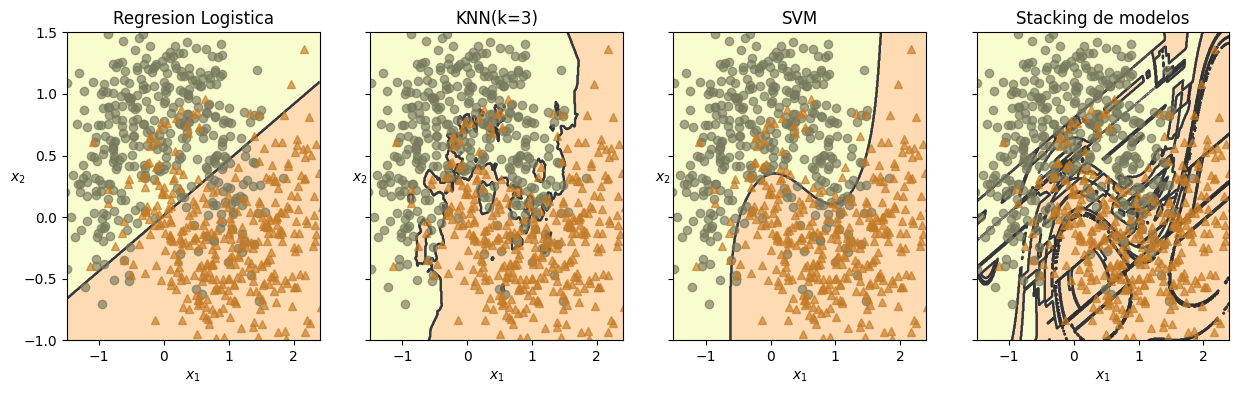

In [ ]:
# Este codigo puede tardar un poco
fig, axes = plt.subplots(ncols=4, figsize=(15, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(stacking_clf.named_estimators_['lr'], X_train, y_train)
plt.title("Regresion Logistica")
plt.sca(axes[1])
plot_decision_boundary(stacking_clf.named_estimators_['knn'], X_train, y_train)
plt.title("KNN(k=3)")
plt.sca(axes[2])
plot_decision_boundary(stacking_clf.named_estimators_['svc'], X_train, y_train)
plt.title("SVM")
plt.sca(axes[3])
plot_decision_boundary(stacking_clf, X_train, y_train)
plt.title("Stacking de modelos")
plt.ylabel("")
plt.show()

### Ejercicio 2

Repetir pero en lugar de usar un árbol para tomar la decisión final, utilice un regresión lógistica.¿Qué puede concluir?

In [17]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors = 3)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)
print(f"Accuracy training : {stacking_clf.score(X_train, y_train):.3f}")
print(f"Accuracy test: {stacking_clf.score(X_test, y_test):.3f}")

Accuracy training : 0.883
Accuracy test: 0.872


## Bagging

La idea de Bagging es combinar modelos conocidos como **strong learners**

    Strong Learner: Modelos que tienen varianza alta y tienden a overfittear.

 El *bagging* consiste en dos pasos diferentes: **bootstrapping** y **agregation**. La idea es utilizar distintos subsets de los datos de entrenamiento para entrenar cada learner generados a partir de un remuestreo de los datos (esto es bootstraping). Los subsets se generan tomando muestras con reemplazo. Si no se hace reemplazo se denomina **pasting**, y si en lugar de tomar subsets sobre los datos, los tomamos sobre los atributos, se denomina **random subspaces**. Luego, la idea es agregar estos resultados (agregation), lo cuál se suele hacer por votación en el caso de la clasificación y promedios en caso de regresión.

https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting

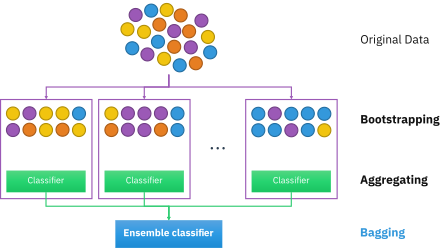

¿Qué diferencia encuentra entre *Voting* y *Bagging*? ¿Qué utilidad tienen hacer bootstrapping?

El modo en que se constuyen los conjuntos para entrenar el modelo.

Para el caso de Bagging, el meta-estimador para clasificación es [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

Este objeto tiene como principal parámetro a **estimator** en el cual instanciaremos un modelo. Veamos un pequeño ejemplo:

In [20]:
from sklearn.ensemble import BaggingClassifier

bg = BaggingClassifier(base_estimator= KNeighborsClassifier(n_neighbors=4), n_estimators=500, max_samples=0.6, max_features=0.6, random_state=42)

# n_estimators nos dice cuantas veces queremos repetir el proceso
# max_samples en float nos dice que porcentaje del training set queremos remuestrear
# max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos

# fit
bg.fit(X_train, y_train)

# evaluación
print("Accuracy training : {:.3f}".format(bg.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(bg.score(X_test, y_test)))

Accuracy training : 0.896
Accuracy test: 0.824


En esta implementación del *BaggingClassifier* no es necesario usar estimadores base que sean *strong learners*, podemos usar cualquier tipo de estimador. Sin embargo, para que bagging performe mejor que el modelo base, si es necesaria esta condición. En el ejemplo recien visto, KNN con 4 vecinos, no es un modelo que pueda sobreajustar tanto como un arbol de profundidad arbitriaria, por lo tanto, no se consideraría un strong learner. Veamos que sucede si utilizabamos el mismo modelo sin bagging

In [21]:
dt = KNeighborsClassifier(n_neighbors=4)

# max_samples en float nos dice que porcentaje del training set queremos remuestrear
# max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos

# fit
dt.fit(X_train, y_train)

# evaluación
print("Accuracy training : {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(dt.score(X_test, y_test)))

Accuracy training : 0.889
Accuracy test: 0.844


En este caso el resultado es muy similar, levemente superior en bagging, pero no se ve una fuerte mejora frente al modelo base, la mejora es marginal.

YO: **EN TEST ES MEJOR EL MODELO BASE!**

### Random Forests

[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) es una implementación de un algoritmo de *Bagging* que propone como estimadores base a **n_estimators** árboles de decisión. Cada árbol verá un subset distinto de los datos de entrenamiento (bagging, llamado **bootstrap** en los parámetros de sklearn). A su vez, para elegir el mejor split en cada nivel, se tienen en cuenta solo **max_features** atributos, seleccionados al azar. Estas 2 técnicas combinadas llevan a obtener árboles que sean distintos entre si y estén decorrelacionados, lo cual es bueno ya que si un árbol comete errores, probablemente otros no lo cometerán y se compensarán. Cuanto más independientes sean los árboles entre si más reduciremos la varianza.

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy training : 1.000
Accuracy test: 0.836


In [39]:
from sklearn.model_selection import RandomizedSearchCV, KFold,ShuffleSplit

parameters = {'n_estimators':range(50, 500, 10), 'max_depth':range(1,6), 'bootstrap':[True, False]}
clf = RandomizedSearchCV(RandomForestClassifier(max_features=None), parameters, n_jobs=10, scoring='accuracy',cv=ShuffleSplit(n_splits=1), n_iter=50) #ShuffleSplit(n_splits=1) para tener 1 solo fold, para dataset muy grandes y largos de entrenar

clf.fit(X_train, y_train)
rf = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

0.8533333333333334 {'n_estimators': 190, 'max_depth': 5, 'bootstrap': True}
Accuracy training : 0.899
Accuracy test: 0.876


In [24]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.210571,0.016671,0.016113,0.002994,200,1,False,"{'n_estimators': 200, 'max_depth': 1, 'bootstr...",0.740000,0.786667,0.766667,0.773333,0.786667,0.770667,0.017179,46
1,0.081070,0.007266,0.005002,0.001264,50,4,True,"{'n_estimators': 50, 'max_depth': 4, 'bootstra...",0.820000,0.913333,0.880000,0.833333,0.880000,0.865333,0.034098,4
2,0.383002,0.023532,0.021607,0.003002,240,5,True,"{'n_estimators': 240, 'max_depth': 5, 'bootstr...",0.813333,0.913333,0.880000,0.840000,0.900000,0.869333,0.037381,1
3,0.536771,0.050949,0.038116,0.006860,440,3,False,"{'n_estimators': 440, 'max_depth': 3, 'bootstr...",0.806667,0.893333,0.866667,0.826667,0.873333,0.853333,0.031833,19
4,0.202657,0.007716,0.012608,0.002420,150,5,False,"{'n_estimators': 150, 'max_depth': 5, 'bootstr...",0.813333,0.880000,0.866667,0.840000,0.853333,0.850667,0.022940,28
5,0.317417,0.024170,0.017904,0.004157,220,4,True,"{'n_estimators': 220, 'max_depth': 4, 'bootstr...",0.826667,0.913333,0.866667,0.840000,0.880000,0.865333,0.030521,7
6,0.666595,0.017061,0.033138,0.004251,450,4,True,"{'n_estimators': 450, 'max_depth': 4, 'bootstr...",0.826667,0.913333,0.866667,0.840000,0.880000,0.865333,0.030521,7
7,0.546436,0.028941,0.030222,0.003737,360,4,True,"{'n_estimators': 360, 'max_depth': 4, 'bootstr...",0.826667,0.913333,0.873333,0.833333,0.880000,0.865333,0.031944,4
8,0.291358,0.015802,0.015804,0.002708,190,5,True,"{'n_estimators': 190, 'max_depth': 5, 'bootstr...",0.820000,0.906667,0.880000,0.833333,0.900000,0.868000,0.035125,3
9,0.254949,0.026765,0.014823,0.002644,200,1,True,"{'n_estimators': 200, 'max_depth': 1, 'bootstr...",0.753333,0.786667,0.760000,0.786667,0.786667,0.774667,0.014847,45


<class 'numpy.ndarray'>


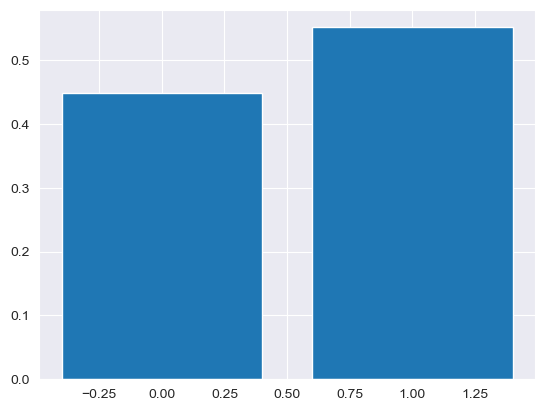

In [28]:
rf = RandomForestClassifier(n_estimators=230, max_depth = 5, bootstrap = True, random_state=0)
rf.fit(X_train, y_train)
feat_importances = rf.feature_importances_
print(type(feat_importances))

plt.bar(np.arange(len(feat_importances)),feat_importances);

La importancia de los atributos en este caso no tienen sentido. Pero en un caso donde la cantidad de atributos sea muy grande es posible en entender cómo funciona el modelo a partir de los datos.

### Fronteras de decisión

![alt text](https://miro.medium.com/max/1776/1*9MixqU7EW3v2I0fIvT8AQQ.png)

![alt text](https://i.stack.imgur.com/RFmcL.png)

### Extremely Randomized Trees

Similar a random forest pero además, en cada nivel del árbol, los splits son tomados al azar en lugar de buscar el óptimo. Random Forest elige la división óptima, mientras que [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) la elige al azar. Sin embargo, una vez que se seleccionan los puntos de división, los dos algoritmos eligen el mejor entre todos los subconjuntos de features. Por lo tanto, Extra Trees agrega aleatorización pero aún tiene optimización, elige el feature con el cual se consiguió una muestra más pura con el corte aleatorio.

Es importante notar que al eliminar esta capa de optimización, el algoritmo en general será más rápido.

Es más robusto a la presencia de atributos ruidosos o poco informativos.

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

clf = RandomizedSearchCV(ExtraTreesClassifier(), parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50)

clf.fit(X_train, y_train)
et = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(et.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(et.score(X_test, y_test)))

0.8559999999999999 {'n_estimators': 440, 'max_depth': 5, 'bootstrap': False}
Accuracy training : 0.860
Accuracy test: 0.868


## Boosting

Los algoritmos de boosting, en lugar de entrenar de forma paralela los árboles utilizando distintos subsets de los datos, entrenan cada árbol de manera secuencial. Un concepto importante es que el tipo de modelos que combinan son **weak learners** e ir reduciendo de a poco su sesgo:

    Weak Learner: Un modelo con alto sesgo y baja varianza, aprende poco y tiene dificultades en generalizar.

La forma en que combinan los weak learners es haciendo que cada nuevo learner corrija los errores del anterior. Un weak learner típico es un árbol de profundidad 1 (**stump**) o árboles con muy poca profundidad.

Lecturas e imagenes extraidas de:
- https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting
- https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

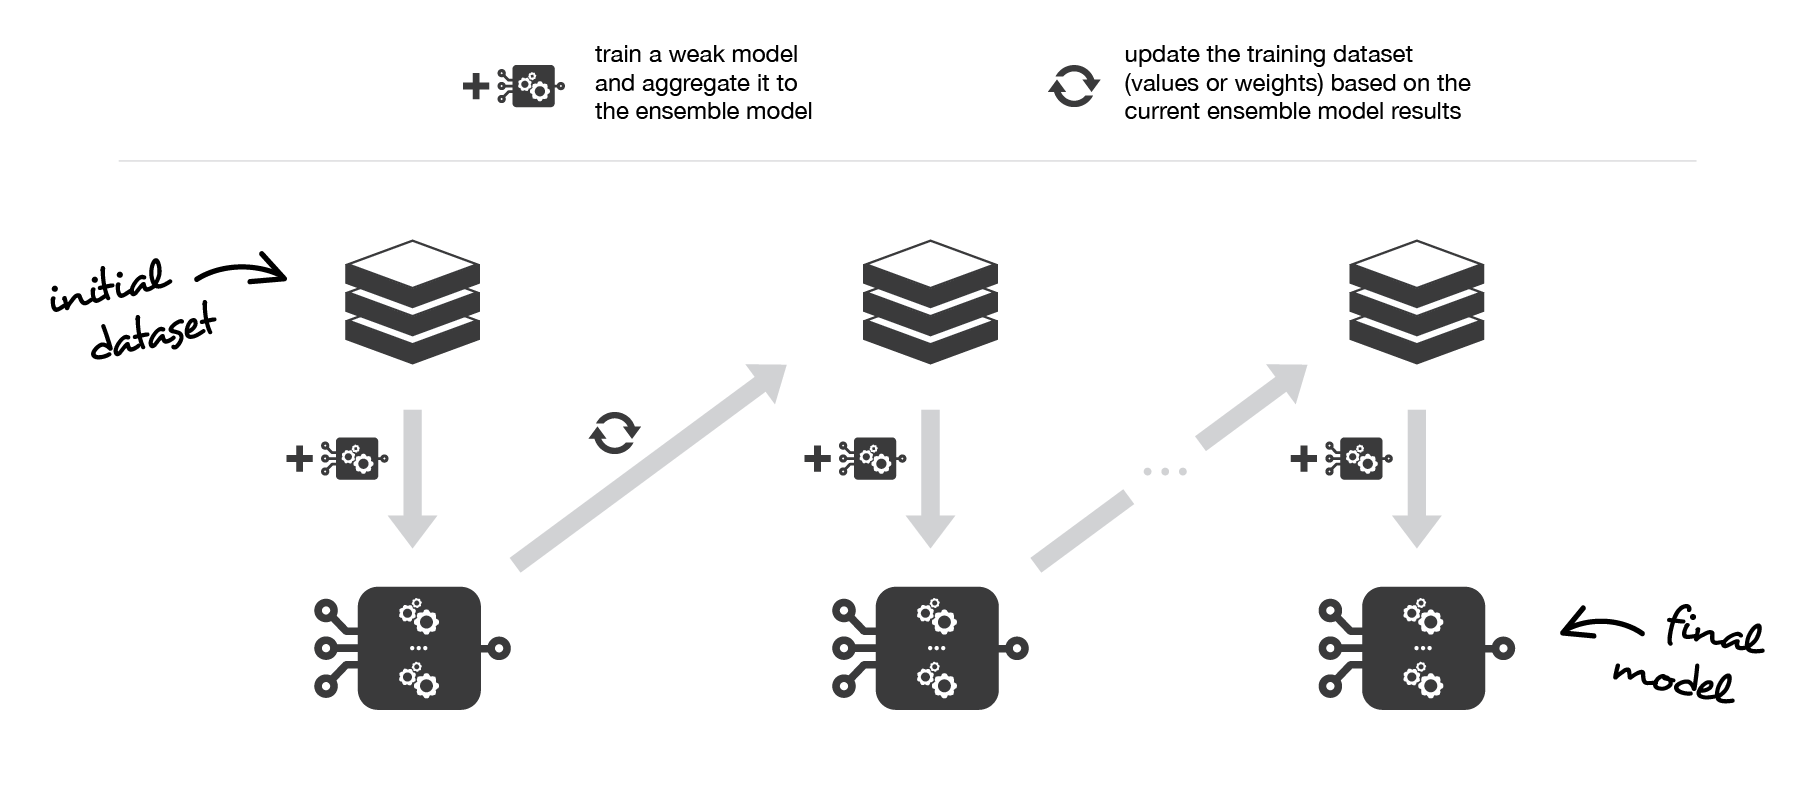

### AdaBoost
En cada iteración construye un stump nuevo y le da más peso a las muestras que fueron clasificadas mal por el anterior stump. De esta manera, en cada iteración se intenta corregir los errores que cometió el anterior clasificador. Una vez armado el ensamble, cada stump tendrá asociado un peso en sus predicciones de acuerdo a qué tan bueno fue clasificando durante el entrenamiento. A continuación les dejamos un [video](https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified) explicativo del funcionamiento del algoritmo.

La implementación de AdaBoost de sklearn nos provee de un meta-estimador para [Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier), al cual le podemos pasar cualquier estimador (por defecto usa un arbol de profundidad 1, un stump).

Paper original:
https://web.stanford.edu/~hastie/Papers/samme.pdf 


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {'n_estimators':range(50, 200, 5),'learning_rate':np.arange(0,1,0.01)}
clf = RandomizedSearchCV(AdaBoostClassifier(), parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50)

clf.fit(X_train, y_train)
ab = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(ab.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(ab.score(X_test, y_test)))

0.868 {'n_estimators': 75, 'learning_rate': 0.25}
Accuracy training : 0.880
Accuracy test: 0.868


### Gradient Boosting (GBM)

Permite elegir una función de costo $L$, por ejemplo, error cuadrático medio si es un problema de regresión, o entropía cruzada si es un problema de clasificación, y cada árbol que construye lo hace de manera que la función de costo se minimice yendo en dirección opuesta al gradiente de la función de costo. Esta técnica de optimización se denomina descenso por gradiente.

![alt text](https://miro.medium.com/max/1400/1*wsBakfF2Geh1zgY4HJbwFQ.gif)

Matematicamente esto significa que cada nueva predicción 

(1) $\hat{y_t} = \hat{y}_{t-1} - \lambda\frac{\partial L}{\partial \hat{y_t}}$

En donde $\lambda$ es la tasa de aprendizaje.

En el caso de error cuadrático:

$L = (y_t - \hat{y}_t)^2$

$\frac{\partial L}{\partial \hat{y_t}} = -2(y_t - \hat{y}_t)$

La parte mágica es que en cada iteración construimos un árbol nuevo que aprenda a predecir $\frac{\partial L}{\partial \hat{y_t}}$, que en este caso es el residuo entre las observaciones y los valores predichos por el árbol anterior. 

Es decir, en este caso cada árbol nuevo lo entreno para que prediga el residuo entre las observaciones y las predicciones anteriores. Luego combino las predicciones de los árboles utilizando la ecuación 1.

En el caso de clasificación, cada árbol va a predecir la diferencia entre la probabilidad asignada a la clase y el outcome de esa clase.

https://www.youtube.com/watch?v=3CC4N4z3GJc&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

In [122]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'n_estimators':range(20, 200, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)}
clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50)

clf.fit(X_train, y_train)
gb = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(gb.score(X_test, y_test)))

0.9574632501904343 {'n_estimators': 20, 'max_depth': 1, 'learning_rate': 0.167}
Accuracy training : 0.957
Accuracy test: 0.957


C:\Users\igalk\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Otros: XGBoost, LightGBM, CatBoost

Existen múltiples implementaciones de los algoritmos de boosting, siendo uno de los más populares el **Extreme Gradient Boosting (XGBoost)** (de los más utilizados en Kaggle junto a los distintos tipos de redes neuronales). Pueden ver una explicación de sus detalles en: https://xgboost.readthedocs.io/en/latest/tutorials/model.html. Luego de la aparición de este algoritmo, surgieron varias empresas que crearon sus versiones, entre ellas Microsoft(**LigthGBM**) y Yandex(**CatBoost**). Estas implementaciones mejoran algunas de las características de XGBoost, como incorporar manejo directo de variables categóricas, manejo de valores faltantes, funciones de pérdida personalizadas y mejoras de complejidad algorítmica. Pueden encontrar una mayor comparativa entre estos algoritmos en https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db. Librerías de cada uno de estos algorítmos:

- XGBoost: https://xgboost.readthedocs.io/en/latest/
    - Ejemplos en https://xgboost.readthedocs.io/en/stable/python/examples/index.html
- LightGBM: https://lightgbm.readthedocs.io/en/latest/#
- CatBoost: https://catboost.ai/


# Ejercicio

1. Importe el conjunto de datos [Stroke Prediction](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

In [2]:
import pandas as pd
import numpy as np


In [3]:

df = pd.read_csv(r"C:\Users\igalk\OneDrive\Documentos\laburo\Data Mining FCEyN\MachineLearning\Lab 7\stroke_data.csv", dtype={"hypertension": str,
        "heart_disease":str })

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 479.2+ KB


In [4]:

df.dropna(inplace=True)

df= df.drop(columns="id")

display(df.head(10))

cols = df.select_dtypes('object').columns.tolist()

for col in cols:
    display(df.groupby([col])[col].count())



,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


gender
Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

hypertension
0    4458
1     451
Name: hypertension, dtype: int64

heart_disease
0    4666
1     243
Name: heart_disease, dtype: int64

ever_married
No     1705
Yes    3204
Name: ever_married, dtype: int64

work_type
Govt_job          630
Never_worked       22
Private          2811
Self-employed     775
children          671
Name: work_type, dtype: int64

Residence_type
Rural    2419
Urban    2490
Name: Residence_type, dtype: int64

smoking_status
Unknown            1483
formerly smoked     837
never smoked       1852
smokes              737
Name: smoking_status, dtype: int64

In [5]:
df = df.drop(df[df.gender == "Other"].index)

X = df.drop(columns="stroke")
y=df[["stroke"]]
X = pd.get_dummies(X)
display(X)

,age,avg_glucose_level,bmi,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,80.0,105.92,32.5,0,1,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,171.23,34.4,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,174.12,24.0,1,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5,81.0,186.21,29.0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,103.08,18.6,1,0,1,0,1,0,1,...,0,0,0,1,1,0,1,0,0,0
5106,81.0,125.20,40.0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,82.99,30.6,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,166.29,25.6,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [8]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled.columns = list(X.columns)
display(X_train_scaled)

,age,avg_glucose_level,bmi,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3.605213,4.735852,3.861225,2.032189,0.000000,0.000000,3.439416,4.558732,0.000000,0.000000,...,0.0,0.000000,2.721009,0.0,2.000031,0.000000,0.000000,0.0,2.067074,0.0
1,3.605213,2.005354,3.383288,0.000000,2.032189,3.439416,0.000000,4.558732,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,2.000031,0.000000,0.000000,0.0,2.067074,0.0
2,2.269949,2.021573,3.571947,2.032189,0.000000,3.439416,0.000000,4.558732,0.000000,0.000000,...,0.0,0.000000,2.721009,0.0,0.000000,2.000031,0.000000,0.0,2.067074,0.0
3,3.293652,2.132632,2.477724,2.032189,0.000000,3.439416,0.000000,4.558732,0.000000,0.000000,...,0.0,0.000000,2.721009,0.0,2.000031,0.000000,2.184732,0.0,0.000000,0.0
4,0.623123,1.746293,2.754424,2.032189,0.000000,3.439416,0.000000,4.558732,0.000000,2.111324,...,0.0,0.000000,2.721009,0.0,2.000031,0.000000,0.000000,0.0,2.067074,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,1.335264,2.564700,4.276275,2.032189,0.000000,3.439416,0.000000,4.558732,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,2.000031,0.000000,0.0,2.067074,0.0
3922,2.447984,2.049282,4.037307,0.000000,2.032189,3.439416,0.000000,4.558732,0.000000,0.000000,...,0.0,2.022816,0.000000,0.0,0.000000,2.000031,2.184732,0.0,0.000000,0.0
3923,3.071108,1.811847,3.672566,0.000000,2.032189,3.439416,0.000000,0.000000,4.558732,0.000000,...,0.0,2.022816,0.000000,0.0,2.000031,0.000000,2.184732,0.0,0.000000,0.0
3924,1.068211,2.027430,3.207206,0.000000,2.032189,3.439416,0.000000,4.558732,0.000000,2.111324,...,0.0,2.022816,0.000000,0.0,0.000000,2.000031,0.000000,0.0,2.067074,0.0


In [10]:
corr = X_train_scaled.corr().style.applymap(lambda x: 'background-color : yellow' if abs(x)>.8 else '')
display(corr)


,age,avg_glucose_level,bmi,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
age,1.000000,0.232619,0.320721,0.025296,-0.025296,-0.274079,0.274079,-0.257337,0.257337,-0.681169,0.681169,0.125345,-0.079161,0.113255,0.325338,-0.628924,-0.019462,0.019462,-0.379226,0.241348,0.113597,0.074590
avg_glucose_level,0.232619,1.000000,0.176937,-0.049153,0.049153,-0.175940,0.175940,-0.150389,0.150389,-0.155697,0.155697,0.007605,-0.018725,0.021355,0.061539,-0.102164,0.007064,-0.007064,-0.101038,0.069695,0.031403,0.012620
bmi,0.320721,0.176937,1.000000,0.022088,-0.022088,-0.166697,0.166697,-0.036763,0.036763,-0.336716,0.336716,0.079750,-0.035728,0.194616,0.071036,-0.434458,0.000070,-0.000070,-0.264313,0.096033,0.102656,0.096893
gender_Female,0.025296,-0.049153,0.022088,1.000000,-1.000000,0.020371,-0.020371,0.089998,-0.089998,-0.036333,0.036333,0.024331,-0.007937,0.026637,0.022507,-0.086093,0.005150,-0.005150,-0.061604,-0.047819,0.097865,-0.002639
gender_Male,-0.025296,0.049153,-0.022088,-1.000000,1.000000,-0.020371,0.020371,-0.089998,0.089998,0.036333,-0.036333,-0.024331,0.007937,-0.026637,-0.022507,0.086093,-0.005150,0.005150,0.061604,0.047819,-0.097865,0.002639
hypertension_0,-0.274079,-0.175940,-0.166697,0.020371,-0.020371,1.000000,-1.000000,0.113615,-0.113615,0.170837,-0.170837,-0.012878,0.021145,0.007812,-0.117000,0.124589,0.008716,-0.008716,0.146136,-0.068304,-0.060193,-0.032808
hypertension_1,0.274079,0.175940,0.166697,-0.020371,0.020371,-1.000000,1.000000,-0.113615,0.113615,-0.170837,0.170837,0.012878,-0.021145,-0.007812,0.117000,-0.124589,-0.008716,0.008716,-0.146136,0.068304,0.060193,0.032808
heart_disease_0,-0.257337,-0.150389,-0.036763,0.089998,-0.089998,0.113615,-0.113615,1.000000,-1.000000,0.111835,-0.111835,-0.004865,0.015238,0.003293,-0.082039,0.086347,0.016123,-0.016123,0.082337,-0.076348,0.024864,-0.057568
heart_disease_1,0.257337,0.150389,0.036763,-0.089998,0.089998,-0.113615,0.113615,-1.000000,1.000000,-0.111835,0.111835,0.004865,-0.015238,-0.003293,0.082039,-0.086347,-0.016123,0.016123,-0.082337,0.076348,-0.024864,0.057568
ever_married_No,-0.681169,-0.155697,-0.336716,-0.036333,0.036333,0.170837,-0.170837,0.111835,-0.111835,1.000000,-1.000000,-0.127850,0.091924,-0.153272,-0.191319,0.541630,0.010474,-0.010474,0.338879,-0.177258,-0.105011,-0.102678


In [11]:
X_train_scaled = X_train_scaled.drop(columns=["gender_Female", "hypertension_0", "heart_disease_0", "ever_married_No", "Residence_type_Rural"])
display(X_train_scaled)

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3.605213,4.735852,3.861225,0.000000,3.439416,0.000000,2.111324,0.000000,0.0,0.000000,2.721009,0.0,0.000000,0.000000,0.0,2.067074,0.0
1,3.605213,2.005354,3.383288,2.032189,0.000000,0.000000,2.111324,2.986951,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.067074,0.0
2,2.269949,2.021573,3.571947,0.000000,0.000000,0.000000,2.111324,0.000000,0.0,0.000000,2.721009,0.0,2.000031,0.000000,0.0,2.067074,0.0
3,3.293652,2.132632,2.477724,0.000000,0.000000,0.000000,2.111324,0.000000,0.0,0.000000,2.721009,0.0,0.000000,2.184732,0.0,0.000000,0.0
4,0.623123,1.746293,2.754424,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.721009,0.0,0.000000,0.000000,0.0,2.067074,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,1.335264,2.564700,4.276275,0.000000,0.000000,0.000000,2.111324,2.986951,0.0,0.000000,0.000000,0.0,2.000031,0.000000,0.0,2.067074,0.0
3922,2.447984,2.049282,4.037307,2.032189,0.000000,0.000000,2.111324,0.000000,0.0,2.022816,0.000000,0.0,2.000031,2.184732,0.0,0.000000,0.0
3923,3.071108,1.811847,3.672566,2.032189,0.000000,4.558732,2.111324,0.000000,0.0,2.022816,0.000000,0.0,0.000000,2.184732,0.0,0.000000,0.0
3924,1.068211,2.027430,3.207206,2.032189,0.000000,0.000000,0.000000,0.000000,0.0,2.022816,0.000000,0.0,2.000031,0.000000,0.0,2.067074,0.0


In [ ]:
####test####

X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_test_scaled.columns = list(X.columns)
X_test_scaled = X_test_scaled.drop(columns=["gender_Female", "hypertension_0", "heart_disease_0", "ever_married_No", "Residence_type_Rural"])

In [29]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [30]:
################
################
#              #
#PARALLEL WORKS#
#              #
################
################

###########
#1) VOTING#
###########


LR = LogisticRegression(random_state=123, solver="saga")
KNN = KNeighborsClassifier()
SVC= SVC(probability=True, random_state=42)

params = {'LR__penalty': [None, "l1", "l2", "elasticnet"],

          "KNN__n_neighbors": np.linspace(1,10,10).astype(int),

          "SVC__kernel": ["linear", "poly", "rbf", "sigmoid"],
          "SVC__degree": [2,3,4]
          }

vot_clas = VotingClassifier(estimators=[('LR', LR), ('KNN', KNN), ('SVC', SVC) ], voting='hard')

RS_vot_clas = RandomizedSearchCV(vot_clas, param_distributions=params,n_iter=4)

RS_vot_clas.fit(X_train_scaled, y_train)

RS_vot_clas_best = RS_vot_clas.best_estimator_

print(f"RS_vot_clas {RS_vot_clas_best.score(X_test_scaled, y_test)}")



C:\Users\igalk\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\igalk\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\igalk\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\igalk\miniconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 292, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "C:\Users\igalk\miniconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 74, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "C:

RS_vot_clas 0.9572301425661914


In [24]:
RS_vot_clas.best_params_

{'SVC__kernel': 'sigmoid',
 'SVC__degree': 3,
 'LR__penalty': 'l1',
 'KNN__n_neighbors': 5}

In [31]:

#############
#2) STACKING#
#############
print("STACKING")

from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

params = {'LR__penalty': [None, "l1", "l2", "elasticnet"],

          "KNN__n_neighbors": np.linspace(1,10,10).astype(int),

          "SVC__kernel": ["linear", "poly", "rbf", "sigmoid"],
          "SVC__degree": [2,3,4],
          }



stack_clas = StackingClassifier(
    estimators=[
        ('LR', LogisticRegression(random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('SVC', SVC(probability=True, random_state=42))
    ],
    final_estimator=DecisionTreeClassifier(random_state=42),
    cv=5  # number of cross-validation folds
)

#RS_stack_clas = RandomizedSearchCV(stack_clas, param_distributions=params,n_iter=4)

param_final_estimator = {'max_depth': [2, 4, 6, 8, 10, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
               }

# create an instance of GridSearchCV for tuning the hyperparameters of the base estimators
gs_base = GridSearchCV(stack_clas, params, cv=5)

# create an instance of GridSearchCV for tuning the hyperparameters of the entire stack
gs_stack = GridSearchCV(stack_clas, {'stack_method': ['auto', 'predict_proba', 'decision_function']}, cv=5)


RS_final_stack_clas = RandomizedSearchCV(stack_clas.final_estimator, param_distributions=param_final_estimator, cv=5, n_iter=10)


# fit the RandomizedSearchCV object to the data for the final estimator
RS_final_stack_clas.fit(X_train_scaled, y_train)

RS_final_stack_clas_best = RS_final_stack_clas.best_estimator_
print(f"RS_stack_clas {RS_final_stack_clas_best.score(X_test_scaled, y_test)}")

STACKING
RS_stack_clas 0.9572301425661914


In [32]:
############
#3) BAGGING#
############
from sklearn.ensemble import BaggingClassifier
params = {'base_estimator__n_neighbors': np.linspace(2,11,10).astype(int),
        'n_estimators': [100, 200, 300, 400, 500], #
        'max_samples': [0.4, 0.6, 0.8],            # todos estos parámetros son para
        'max_features': [0.4, 0.6, 0.8],           # ajustar el bagging
        'bootstrap': [True, False]                 #
            }

BG = BaggingClassifier(base_estimator= KNeighborsClassifier(), random_state=42)

BG_CV= RandomizedSearchCV(BG, param_distributions=params)

BG_CV.fit(X_train_scaled, y_train.values.ravel())

BG_CV_best = BG_CV.best_estimator_

print(f"RS_stack_clas {BG_CV_best.score(X_test_scaled, y_test)}")





RS_stack_clas 0.9572301425661914


In [33]:

####################
#3.1) RANDOM FOREST#
####################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold,ShuffleSplit

parameters = {"criterion": ["gini", "entropy"],
              'n_estimators':range(50, 500, 10),
              'max_depth':range(1,6),
              'bootstrap':[True, False]}

RFC = RandomForestClassifier(max_features=None)

RFC_cv = RandomizedSearchCV(RFC, param_distributions= parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50) #ShuffleSplit(n_splits=1) para tener 1 solo fold, para dataset muy grandes y largos de entrenar

RFC_cv.fit(X_train_scaled, y_train)
RFC_cv_best = RFC_cv.best_estimator_ ### por qué necesito esta linea???

print("Accuracy test: {:.3f}".format(RFC_cv_best.score(X_test_scaled, y_test.values.ravel())))


Accuracy test: 0.957


C:\Users\igalk\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [34]:
#################################
#3.2) Extremely Randomized Trees#
#################################

from sklearn.ensemble import ExtraTreesClassifier

parameters = {'n_estimators':range(50, 500, 10),
              'max_depth':range(1,6),
              'max_features': range(5, 10),
              'max_leaf_nodes': range(3, 5),
              'bootstrap':[True, False],
              }


ETC = ExtraTreesClassifier()
clf_cv = RandomizedSearchCV(ETC, parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50)

clf_cv.fit(X_train_scaled, y_train)
etc_cv_best = clf_cv.best_estimator_
print("Accuracy test: {:.3f}".format(etc_cv_best.score(X_test_scaled, y_test)))





C:\Users\igalk\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Accuracy test: 0.957


In [0]:

##############
##############
#            #
#SERIAL WORKS#
#            #
##############
##############

#############
#1) BOOSTING#
#############

In [51]:

################
#1.1) Ada Boost#
################
from sklearn.ensemble import AdaBoostClassifier

parameters = {'n_estimators':range(50, 200, 5),
              'learning_rate':np.arange(0,1,0.01),
              "base_estimator": [RandomForestClassifier(), DecisionTreeClassifier()]
              }

ADA_cv = RandomizedSearchCV(AdaBoostClassifier(random_state=123), parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50)

ADA_cv.fit(X_train_scaled, y_train.values.ravel())
ADA_cv_best = ADA_cv.best_estimator_
print(ADA_cv_best, ADA_cv_best.feature_importances_)
print("Accuracy test: {:.3f}".format(ADA_cv_best.score(X_test_scaled, y_test.values.ravel())))

AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.68,
                   n_estimators=145, random_state=123) [2.21679803e-01 2.73211960e-01 2.51645984e-01 3.15471978e-02
 2.65855131e-02 2.12203474e-02 1.76429549e-02 1.39530601e-02
 5.52959565e-06 2.00303229e-02 1.78904670e-02 9.98148021e-04
 3.31579931e-02 1.44023664e-02 1.94669325e-02 2.09035682e-02
 1.56578521e-02]
Accuracy test: 0.958


In [53]:
########################
#1.2) Gradient Boosting#
########################

from sklearn.ensemble import GradientBoostingClassifier

parameters = {"loss": ["log_loss", "deviance", "exponential"],
              'n_estimators':range(20, 200, 5),
              'max_depth':range(1,7),
              'learning_rate':np.arange(0,1,0.001),
              "max_features": ["auto", "sqrt", "log2"]
              }
GBC_CV = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_jobs=10, scoring='accuracy',cv=5, n_iter=50)

GBC_CV.fit(X_train_scaled, y_train)
GBC_CV_best = GBC_CV.best_estimator_

print("Accuracy test: {:.3f}".format(GBC_CV_best.score(X_test_scaled, y_test)))


Accuracy test: 0.957


C:\Users\igalk\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.95109512 0.95695402        nan 0.93632583 0.94803682 0.95287726
 0.93988687 0.95746325 0.9546607  0.95211261        nan        nan
 0.94625565 0.95287791 0.86965236 0.93148085 0.95313269 0.94982156
 0.95287856 0.95185848 0.94956678 0.95517058        nan 0.95644447
 0.95720847        nan        nan 0.95669892 0.95287726        nan
 0.9541518  0.95134957 0.93606619 0.95084002 0.95746325 0.95313269
 0.95389734 0.95567981        nan 0.94752824        nan 0.95746325
 0.95720847 0.9577177  0.95084132 0.9541505  0.94854767 0.95720847
 0.95084034 0.93734137]
  warnings.warn(
C:\Users\igalk\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [64]:

##############
#1.3) XGBoost#
##############
import xgboost as xgb
xgb = xgb.XGBClassifier(n_jobs=None) # recomendación de la documentación
                                    #https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html#number-of-parallel-threads

parameters = {'n_estimators':range(20, 200, 5),
              'max_depth':range(1,7),
             }

xgb_CV = RandomizedSearchCV(xgb, parameters, n_jobs=1, cv=5, random_state=123) #n_jobs=1 recomendación de la documentación

xgb_CV.fit(X_train_scaled, y_train)
print(xgb_CV.best_score_, "\n", xgb_CV.best_params_, "\n", xgb_CV.best_estimator_)

xgb_CV_best= xgb_CV.best_estimator_

print("Accuracy test: {:.3f}".format(xgb_CV_best.score(X_test_scaled, y_test)))







0.9569536960503072 
 {'n_estimators': 175, 'max_depth': 1} 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy test: 0.957



2. Entrene y evalue los modelos vistos en esta notebook en este dataset. Utilice cross validation de 5 folds para esta tarea.







3. Comparen los modelos.